
# Corn Leaf Disease Detection with Enhanced KNN (EKNN)

Pipeline:

1. Pre-processing (normalisasi, grayscale, reduksi noise)
2. Segmentasi dengan **Otsu Thresholding**
3. Ekstraksi fitur (Fine, Coarse, DOR)
4. Klasifikasi dengan Enhanced K-Nearest Neighbour (EKNN)
5. Evaluasi: Confusion Matrix, Classification Report, ROC multi-kelas
6. Visualisasi: Before–After preprocessing & segmentasi per kelas.


In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install scikit-learn

In [2]:


import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

print("Libraries loaded.")


Libraries loaded.


# EDA

In [3]:
# Pertama, mari kita periksa struktur internal archive.zip
print("Listing contents of archive.zip:")
!unzip -l /content/dataset.zip
print("\n")
!unzip dataset.zip -d /content/

# Periksa apa yang sebenarnya ada di direktori /content/ setelah unzip
print("Listing contents of /content/ after unzip:")
!ls -R /content/
print("\n")

base_dir = "/content/dataset"   # BUKAN /content/dataset

classes = os.listdir(base_dir)
class_counts = {}

for c in classes:
    class_path = os.path.join(base_dir, c)
    num_files = len(os.listdir(class_path))
    class_counts[c] = num_files

class_counts

# Set direktori dataset utama. Kini daxtaset berada di /content/dataset
BASE_DIR = "/content/dataset"

CLASS_MAP = {
    "daun sehat": "HL",   # Healthy Leaf
    "daun rusak": "DMG",  # Damaged Leaf
    "hawar daun": "NLB",  # Northern Leaf Blight
    "karat daun": "RS"    # Rust
}

print("Base directory for dataset processing:", BASE_DIR)
print("Kelas yang diharapkan:", CLASS_MAP)

Listing contents of archive.zip:
Archive:  /content/dataset.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2025-12-09 15:37   dataset/
        0  2025-12-09 14:51   dataset/daun rusak/
    27882  2025-11-30 10:22   dataset/daun rusak/(1)_result.jpg
    29394  2025-11-30 10:22   dataset/daun rusak/(10)_result.jpg
    23577  2025-11-30 10:22   dataset/daun rusak/(11)_result.jpg
    24150  2025-11-30 10:22   dataset/daun rusak/(12)_result.jpg
    24634  2025-11-30 10:22   dataset/daun rusak/(13)_result.jpg
    24713  2025-11-30 10:22   dataset/daun rusak/(14)_result.jpg
    24258  2025-11-30 10:22   dataset/daun rusak/(15)_result.jpg
    24486  2025-11-30 10:22   dataset/daun rusak/(16)_result.jpg
    24462  2025-11-30 10:22   dataset/daun rusak/(17)_result.jpg
    22416  2025-11-30 10:22   dataset/daun rusak/(18)_result.jpg
    23671  2025-11-30 10:22   dataset/daun rusak/(19)_result.jpg
    29246  2025-11-30 10:22   dataset/daun rusak/(2)_result.jpg

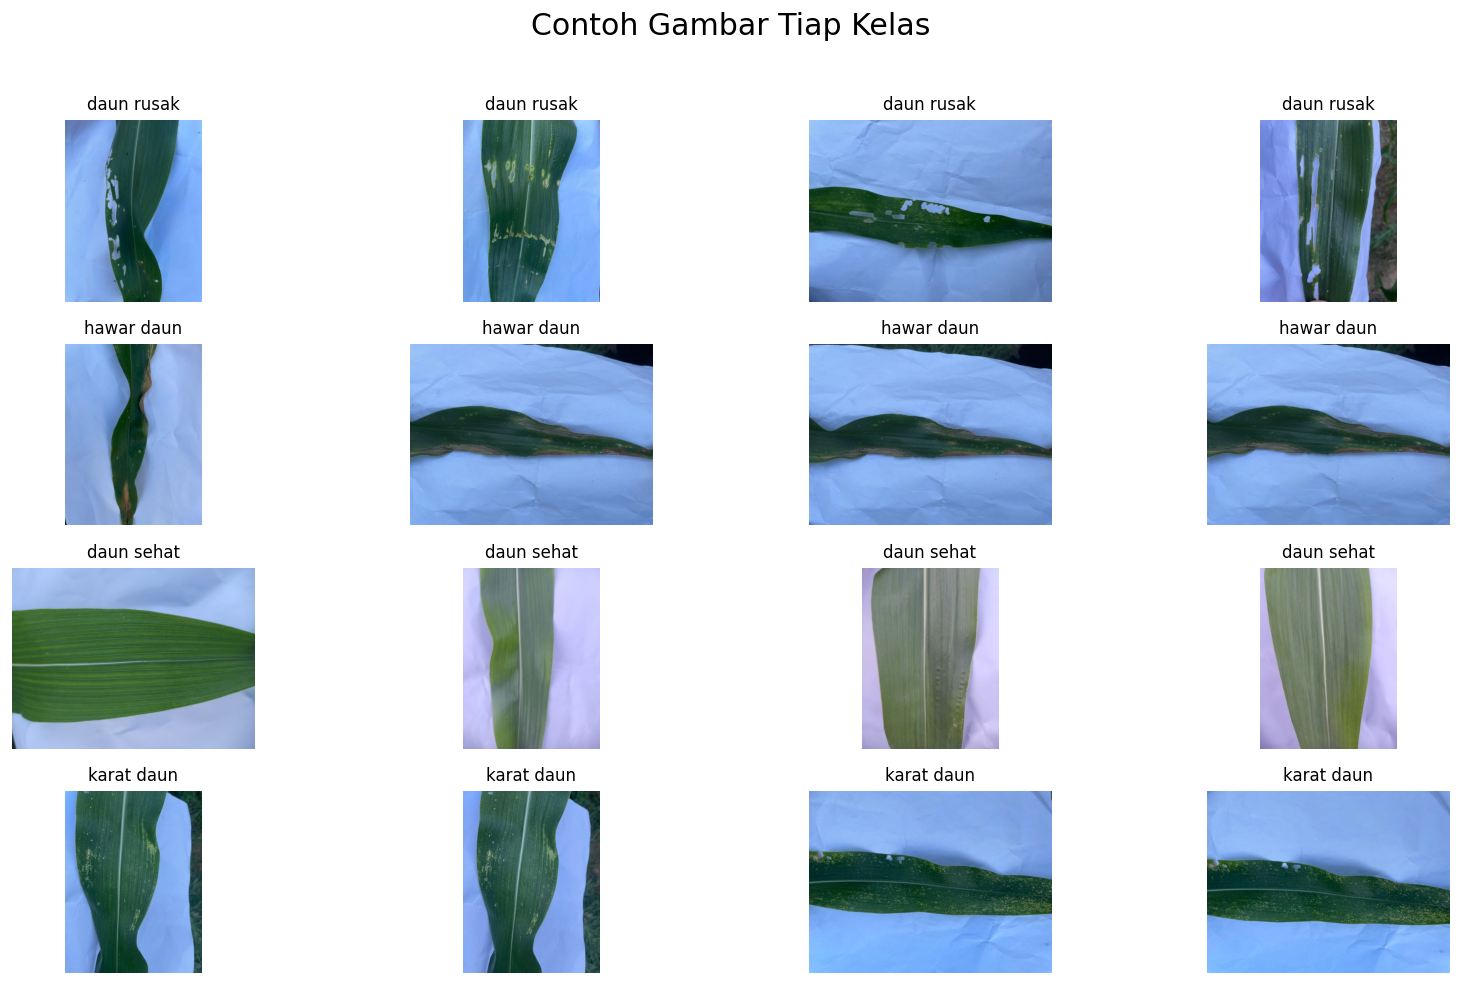

In [6]:
# Kontruksi Data Awal
import math
import os
import pandas as pd

# Reconstruct df_raw for EDA purposes here, as it's missing
data = []
for class_name in classes:
    folder_path = os.path.join(BASE_DIR, class_name)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(folder_path, filename)
                data.append({"filepath": filepath, "label": class_name})

df_raw = pd.DataFrame(data)

num_samples = 4  # jumlah contoh tiap kelas
plt.figure(figsize=(14, 8))

total_slots = len(classes) * num_samples

rows = len(classes)
cols = num_samples

plt.suptitle("Contoh Gambar Tiap Kelas", fontsize=18, y=1.02)

plot_index = 1
for label in classes:
    class_files = df_raw[df_raw['label'] == label].sample(num_samples, random_state=42)

    for filepath in class_files["filepath"]:
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, plot_index)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis("off")
        plot_index += 1

plt.tight_layout()
plt.show()


Jumlah gambar per kelas:
{'daun rusak': 97, 'hawar daun': 15, 'daun sehat': 227, 'karat daun': 18}


/tmp/ipython-input-906602014.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_raw, x="label", palette="viridis")


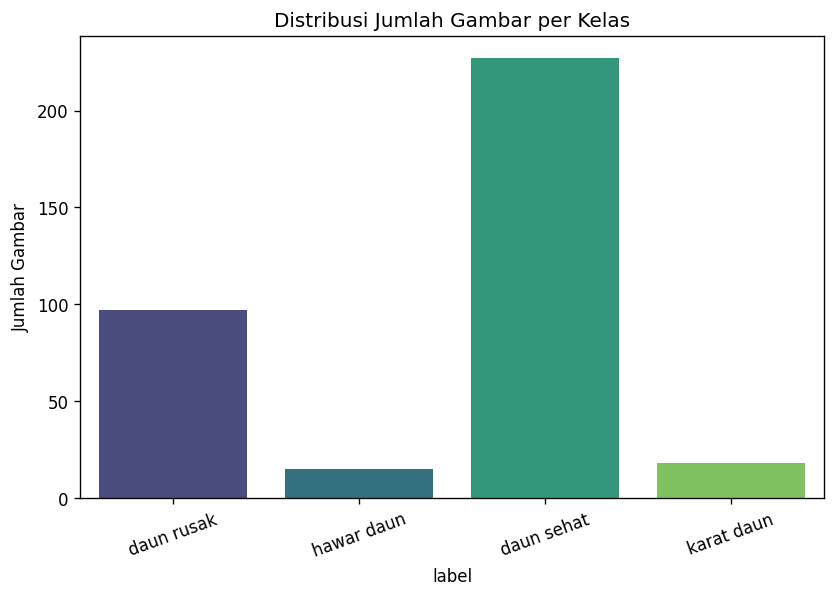


Jumlah gambar per kelas:
label
daun sehat    227
daun rusak     97
karat daun     18
hawar daun     15
Name: count, dtype: int64


In [7]:
# Distribusi Kelas
classes = os.listdir(base_dir)
class_counts = {}

for c in classes:
    class_path = os.path.join(base_dir, c)
    num_files = len(os.listdir(class_path))
    class_counts[c] = num_files

print("\nJumlah gambar per kelas:")
print(class_counts)

class_counts = df_raw["label"].value_counts()

plt.figure(figsize=(8,5))
sns.countplot(data=df_raw, x="label", palette="viridis")
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xticks(rotation=20)
plt.ylabel("Jumlah Gambar")
plt.show()

print("\nJumlah gambar per kelas:")
print(class_counts)

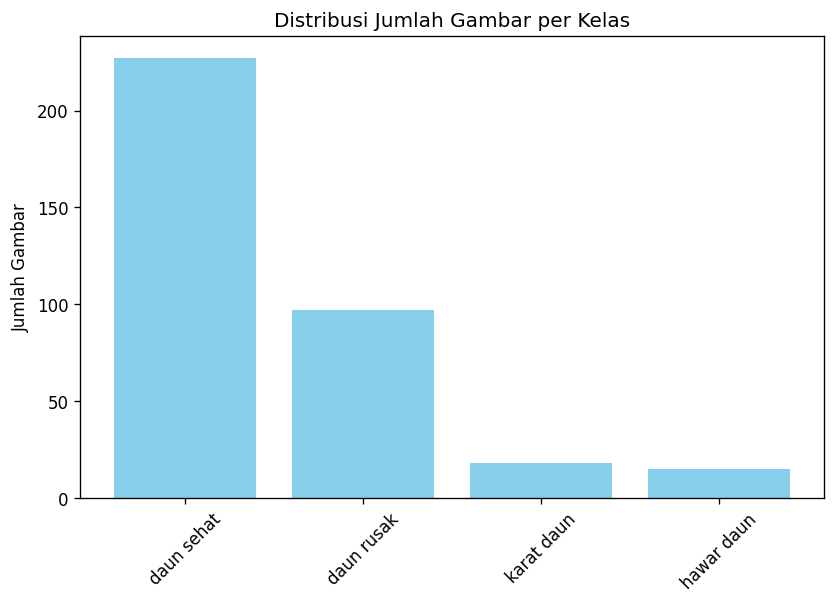

In [8]:
# Visualisasi jumlah gambar
plt.figure(figsize=(8,5))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xticks(rotation=45)
plt.ylabel("Jumlah Gambar")
plt.show()


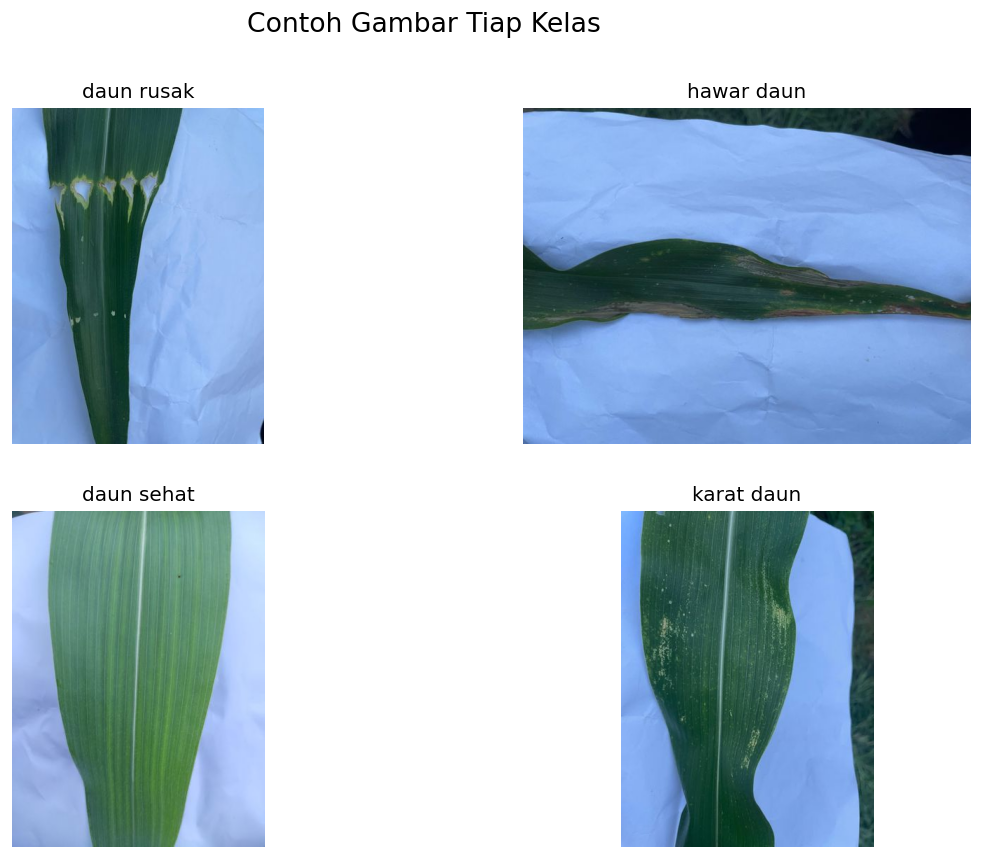

In [9]:
# Tampilan contoh gambar per kelas
plt.figure(figsize=(12, 8))

for idx, c in enumerate(classes):
    folder_path = os.path.join(base_dir, c)
    img_name = os.listdir(folder_path)[0]  # Ambil 1 gambar pertama
    img_path = os.path.join(folder_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, idx+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")

plt.suptitle("Contoh Gambar Tiap Kelas", fontsize=16)
plt.show()

In [10]:
# Analisis Ukuran gambar (tinggi dan lebar)
sizes = []

for c in classes:
    folder_path = os.path.join(base_dir, c)
    for f in os.listdir(folder_path):
        img_path = os.path.join(folder_path, f)
        img = cv2.imread(img_path)

        if img is None:
            continue

        h, w = img.shape[:2]
        sizes.append((h, w))

sizes[:5]


[(480, 360), (480, 360), (480, 360), (480, 360), (480, 360)]

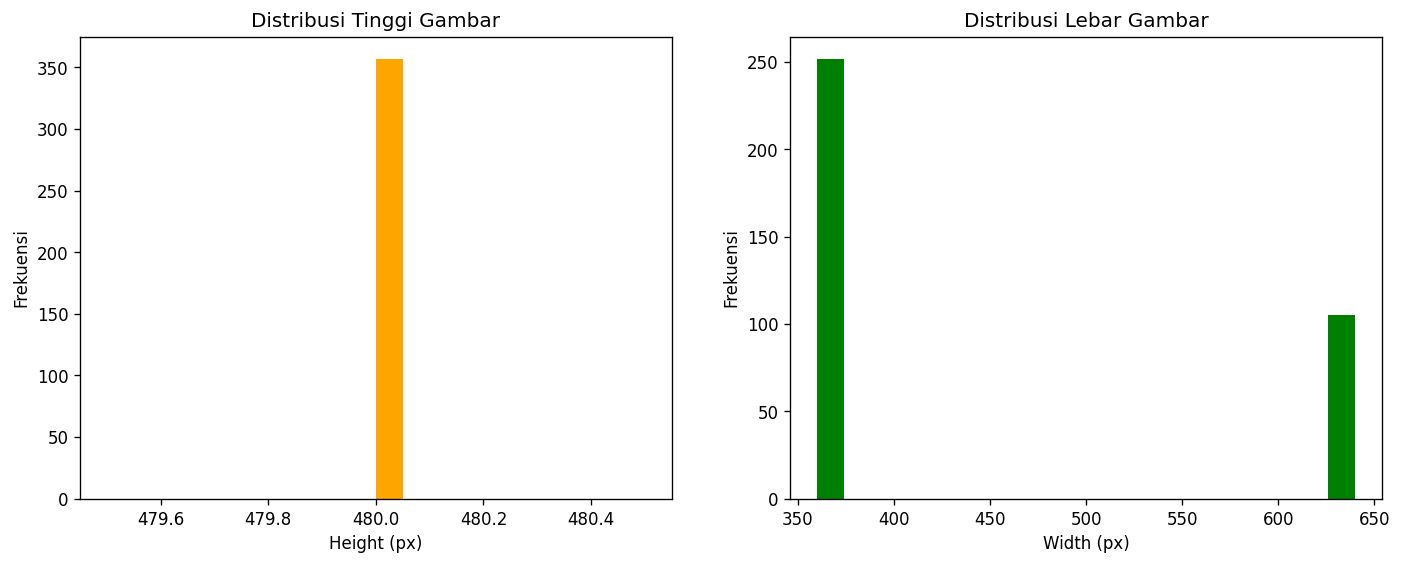

In [11]:
# Visualisasi Distribusi ukuran gambar
heights = [s[0] for s in sizes]
widths  = [s[1] for s in sizes]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=20, color='orange')
plt.title("Distribusi Tinggi Gambar")
plt.xlabel("Height (px)")
plt.ylabel("Frekuensi")

plt.subplot(1, 2, 2)
plt.hist(widths, bins=20, color='green')
plt.title("Distribusi Lebar Gambar")
plt.xlabel("Width (px)")
plt.ylabel("Frekuensi")

plt.show()


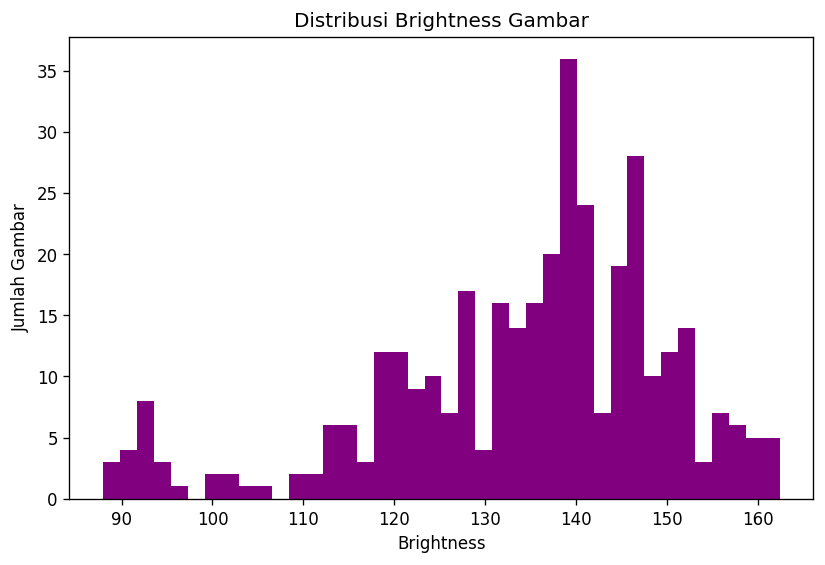

In [12]:
# Analisis Brightness (Tinhkat kecerahan gambar)
brightness = []

for c in classes:
    folder_path = os.path.join(base_dir, c)
    for f in os.listdir(folder_path):
        img_path = os.path.join(folder_path, f)
        img = cv2.imread(img_path)

        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness.append(gray.mean())

plt.figure(figsize=(8,5))
plt.hist(brightness, bins=40, color='purple')
plt.title("Distribusi Brightness Gambar")
plt.xlabel("Brightness")
plt.ylabel("Jumlah Gambar")
plt.show()

In [13]:
# KONVERSI MENJADI FITUR NUMERIK SEDERHANA (UNTUK EDA ML)

def preprocess_to_vector(path, size=(64,64)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, size)
    return img.flatten()

samples_per_class = 3
processed_rows = []

for label in classes:
    subset = df_raw[df_raw["label"] == label].sample(samples_per_class, random_state=42)

    for _, row in subset.iterrows():
        fp = row["filepath"]
        feat = preprocess_to_vector(fp)

        processed_rows.append([label] + feat.tolist())

# Buat dataframe
df_processed_preview = pd.DataFrame(processed_rows)
df_processed_preview.rename(columns={0: "label"}, inplace=True)

print("=== Contoh Fitur Setelah Preprocessing (Per Kelas) ===")
display(df_processed_preview.iloc[:, :25])  # menampilkan 25 fitur pertama agar tidak besar

=== Contoh Fitur Setelah Preprocessing (Per Kelas) ===


,label,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,daun rusak,120,124,126,122,123,122,118,122,124,...,139,147,155,163,166,165,164,160,157,163
1,daun rusak,160,160,162,170,171,181,185,184,178,...,73,84,74,60,59,80,97,78,71,70
2,daun rusak,191,188,188,187,186,183,183,183,182,...,182,186,154,147,152,170,168,173,173,175
3,hawar daun,189,187,185,185,183,185,181,179,179,...,180,178,176,165,155,143,133,126,70,63
4,hawar daun,189,186,185,184,185,184,185,183,183,...,181,179,178,178,177,176,178,173,175,187
5,hawar daun,71,62,59,60,65,54,64,59,49,...,46,59,53,60,37,55,51,47,53,53
6,daun sehat,187,190,193,195,194,192,196,197,199,...,190,188,186,184,184,184,184,184,185,182
7,daun sehat,213,214,214,214,214,210,200,185,142,...,116,113,109,120,114,118,112,122,125,117
8,daun sehat,151,162,166,158,159,163,171,178,175,...,114,117,120,114,123,124,125,120,124,124
9,karat daun,176,173,168,162,158,152,94,86,78,...,74,74,73,79,78,81,79,73,86,89



Missing values total: 0
Tidak ada missing value (normal untuk dataset citra).


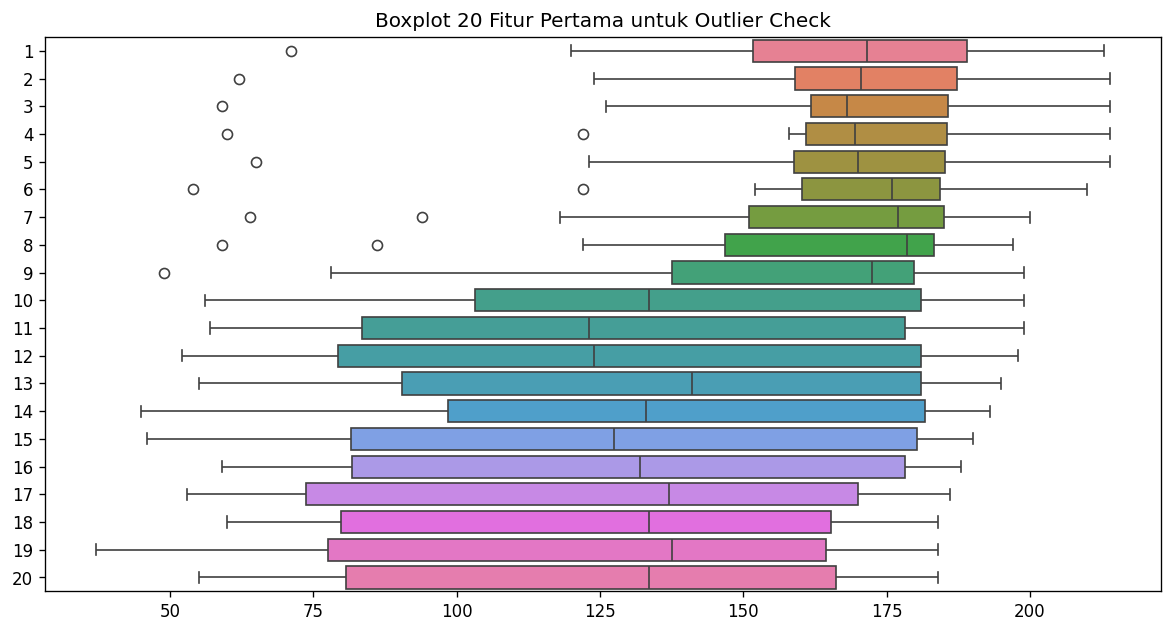

In [15]:
# karena citra maka tidak akan ada missing value
df_features = df_processed_preview.drop('label', axis=1)
missing = df_features.isnull().sum().sum()
print("\nMissing values total:", missing)

if missing == 0:
    print("Tidak ada missing value (normal untuk dataset citra).")

# Outlier
plt.figure(figsize=(12,6))
sns.boxplot(data=df_features.iloc[:, :20], orient='h')
plt.title("Boxplot 20 Fitur Pertama untuk Outlier Check")
plt.show()

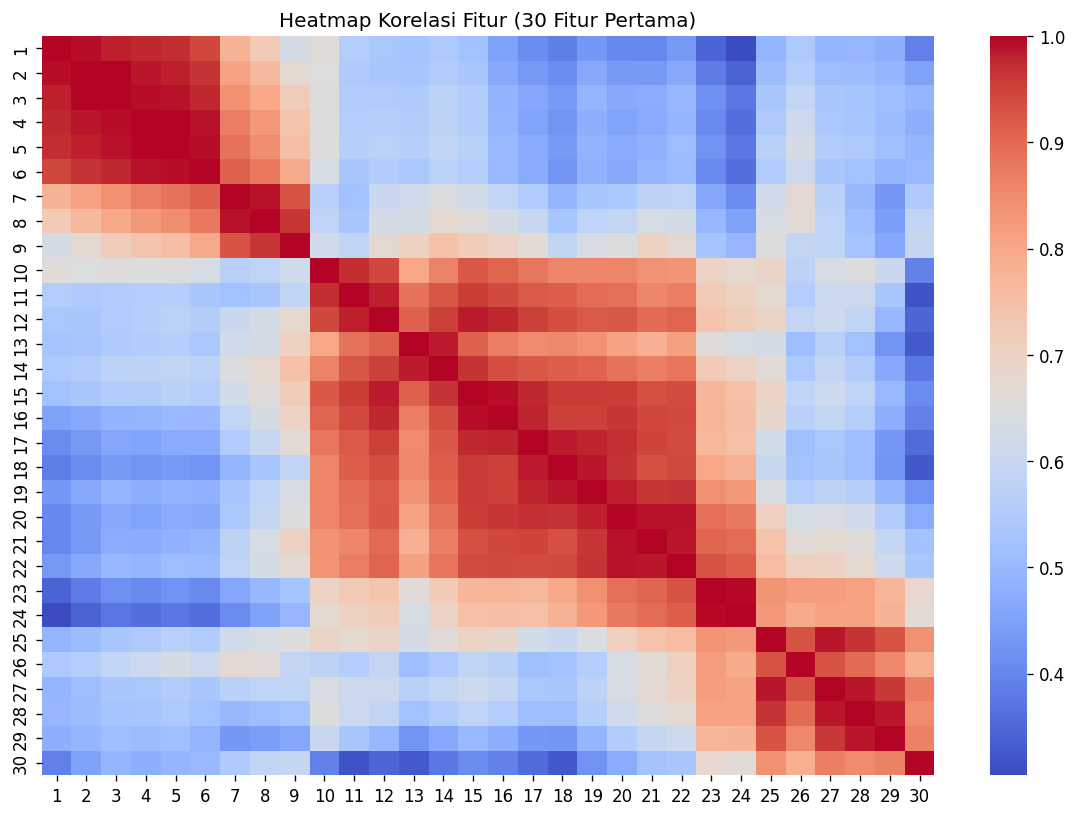

In [16]:
# Heatmap
plt.figure(figsize=(12,8))
corr = df_features.iloc[:, :30].corr()
sns.heatmap(corr, cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur (30 Fitur Pertama)")
plt.show()

In [18]:

print("\n=== RINGKASAN EDA DATASET ===")
print("Jumlah total gambar :", len(df_raw))
print("Jumlah kelas        :", df_raw['label'].nunique())
print("Distribusi kelas    :\n", df_raw['label'].value_counts())
print("Rata-rata tinggi    :", np.mean(heights))
print("Rata-rata lebar     :", np.mean(widths))
print("Rata-rata brightness:", np.mean(brightness))
print("Dimensi fitur per gambar setelah preprocessing :", df_features.shape[1])


=== RINGKASAN EDA DATASET ===
Jumlah total gambar : 357
Jumlah kelas        : 4
Distribusi kelas    :
 label
daun sehat    227
daun rusak     97
karat daun     18
hawar daun     15
Name: count, dtype: int64
Rata-rata tinggi    : 480.0
Rata-rata lebar     : 442.3529411764706
Rata-rata brightness: 134.3887057005962
Dimensi fitur per gambar setelah preprocessing : 4096


## Preprocessing

In [19]:

# ===================================================================================
# PRE-PROCESSING & SEGMENTASI
# ===================================================================================

def preprocess_image(img, target_size=(256, 256)):
    """
    Preprocessing citra daun jagung.

    Tahapan:
    1. Resize ke ukuran target (default 256x256, sejalan dengan PlantVillage).
    2. BGR (OpenCV) -> RGB.
    3. Normalisasi piksel ke [0, 1].
    4. Konversi ke grayscale.
    """
    img_resized = cv2.resize(img, target_size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_rgb_norm = img_rgb.astype("float32") / 255.0
    gray = cv2.cvtColor((img_rgb_norm * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
    return img_rgb_norm, gray


def segment_otsu(gray):
    """
    Segmentasi Otsu berbasis intensitas.

    1. Gaussian blur untuk mereduksi noise.
    2. Thresholding Otsu -> citra biner.
    """
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, otsu_binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_binary


Contoh visualisasi before-after per kelas:

Kelas: daun sehat, contoh file: /content/dataset/daun sehat/(79)_result.jpg


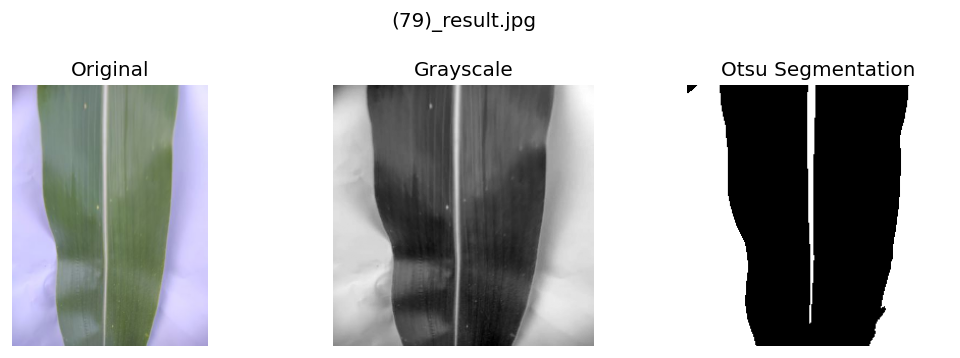

Kelas: daun rusak, contoh file: /content/dataset/daun rusak/(21)_result.jpg


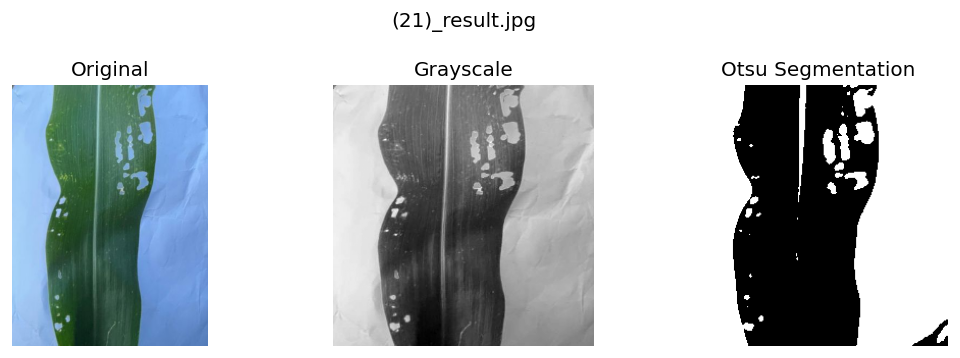

Kelas: hawar daun, contoh file: /content/dataset/hawar daun/1 (25)_result.jpg


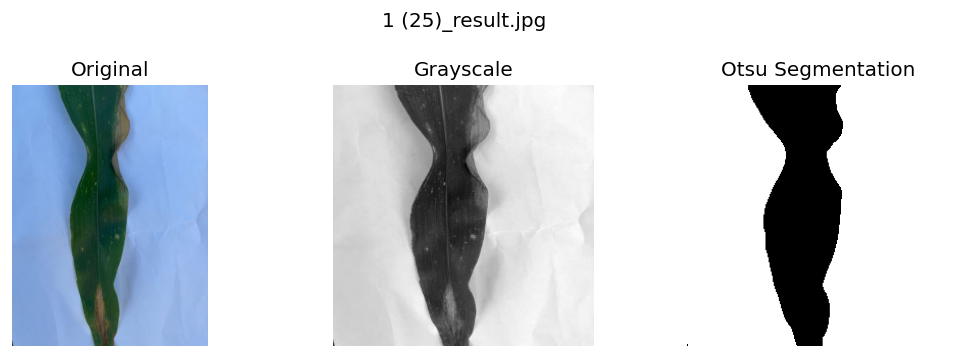

Kelas: karat daun, contoh file: /content/dataset/karat daun/1 (7)_result.jpg


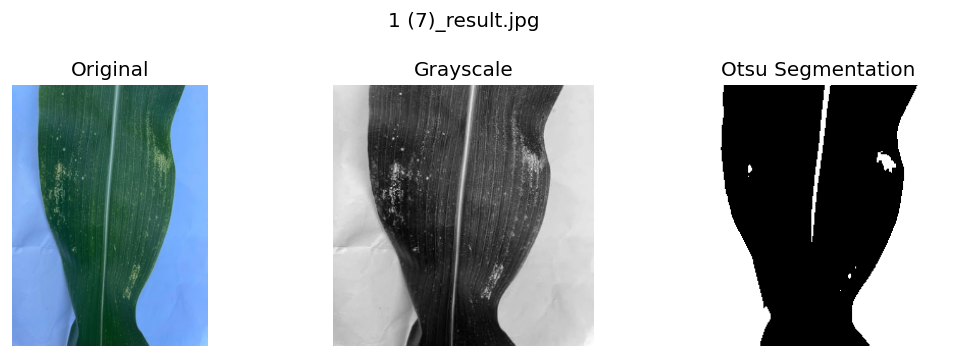

In [20]:

# ===================================================================================
# VISUALISASI: BEFORE–AFTER PREPROCESSING & OTSU SEGMENTATION
# ===================================================================================

import random

def show_before_after(path):
    """
    Menampilkan:
    - Citra asli (RGB)
    - Citra grayscale
    - Hasil segmentasi Otsu
    """
    img = cv2.imread(path)
    if img is None:
        print("Gagal membaca citra:", path)
        return

    rgb_norm, gray = preprocess_image(img)
    otsu_bin = segment_otsu(gray)

    plt.figure(figsize=(9, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gray, cmap="gray")
    plt.title("Grayscale")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(otsu_bin, cmap="gray")
    plt.title("Otsu Segmentation")
    plt.axis("off")

    plt.suptitle(os.path.basename(path))
    plt.tight_layout()
    plt.show()


print("Contoh visualisasi before-after per kelas:\n")
for folder_name in CLASS_MAP.keys():
    folder_path = os.path.join(BASE_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue
    files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not files:
        continue
    sample_path = os.path.join(folder_path, random.choice(files))
    print(f"Kelas: {folder_name}, contoh file: {sample_path}")
    show_before_after(sample_path)


In [21]:
# ===================================================================================
# EKSTRAKSI FITUR: FINE, COARSE, DOR
# ===================================================================================

# ---------- FINE FEATURES (LBP-like rotation invariant) ----------
def extract_fine_features(gray, radius=1, neighbors=8, step=2):
    h, w = gray.shape
    codes = []

    for y in range(radius, h - radius, step):
        for x in range(radius, w - radius, step):
            center = gray[y, x]
            binary = []
            for n in range(neighbors):
                theta = 2 * np.pi * n / neighbors
                yy = int(round(y + radius * np.sin(theta)))
                xx = int(round(x + radius * np.cos(theta)))
                binary.append(1 if gray[yy, xx] >= center else 0)

            # Rotation invariant
            rotations = [
                int("".join(map(str, binary[i:] + binary[:i])), 2)
                for i in range(neighbors)
            ]
            codes.append(min(rotations))

    hist, _ = np.histogram(codes, bins=256, range=(0,256))
    hist = hist.astype("float32")
    hist /= (hist.sum() + 1e-8)
    return hist


# ---------- COARSE FEATURES (gradient magnitude) ----------
def extract_coarse_features(gray, num_bins=32):
    sobelx = cv2.Sobel(gray.astype("float32"), cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray.astype("float32"), cv2.CV_32F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    hist, _ = np.histogram(magnitude, bins=num_bins, range=(0, magnitude.max()+1e-8))
    hist = hist.astype("float32")
    hist /= (hist.sum() + 1e-8)
    return hist


# ---------- DOR FEATURES ----------
def extract_dor_features(gray, window_size=5):
    assert window_size % 2 == 1, "window_size harus ganjil"

    pad = window_size // 2
    padded = np.pad(gray.astype("float32"), pad, mode="reflect")
    h, w = gray.shape
    dom_idx = []

    for y in range(h):
        for x in range(w):
            region = padded[y:y+window_size, x:x+window_size]
            center = padded[y+pad, x+pad]

            diffs = np.abs(region - center).flatten()
            dom_idx.append(np.argmax(diffs))

    num_pos = window_size * window_size
    hist, _ = np.histogram(dom_idx, bins=num_pos, range=(0, num_pos))
    hist = hist.astype("float32")
    hist /= (hist.sum() + 1e-8)
    return hist


In [22]:
# Wrapper
# ===================================================================================
# GABUNGKAN SEMUA FITUR MENJADI 1 VEKTOR
# ===================================================================================

def extract_all_features(gray):
    fine   = extract_fine_features(gray)
    coarse = extract_coarse_features(gray)
    dor    = extract_dor_features(gray)

    # Total fitur = 256 + 32 + 25 = 313 dimensi
    return np.concatenate([fine, coarse, dor]).astype("float32")


In [23]:
# Pipeline
# ===================================================================================
# PIPELINE UTAMA: PATH → PREPROCESSING → OTSU → FITUR
# ===================================================================================

def process_image_to_vector(path):
    img = cv2.imread(path)
    if img is None:
        print("Gagal membaca:", path)
        return None

    rgb_norm, gray = preprocess_image(img)
    otsu_mask = segment_otsu(gray)
    feat_vec = extract_all_features(gray)

    return feat_vec


In [1]:
joblib.dump(scaler, "scaler.pkl")


NameError: name 'joblib' is not defined

In [24]:
# ===================================================================================
# MEMBANGUN X (FITUR) DAN y (LABEL)
# ===================================================================================

from tqdm import tqdm

X = []
y = []

print("Memulai ekstraksi fitur seluruh dataset...\n")

for fp, label in tqdm(zip(df_raw["filepath"], df_raw["label"]), total=len(df_raw)):
    feat = process_image_to_vector(fp)
    X.append(feat)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("Contoh fitur satu gambar:", X[0][:10])


Memulai ekstraksi fitur seluruh dataset...



100%|██████████| 357/357 [11:48<00:00,  1.99s/it]

X shape: (357, 313)
Contoh fitur satu gambar: [0.01822804 0.04284209 0.         0.02864406 0.         0.00384401
 0.         0.05939612 0.         0.00737801]


In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Label mapping: {np.str_('daun rusak'): np.int64(0), np.str_('daun sehat'): np.int64(1), np.str_('hawar daun'): np.int64(2), np.str_('karat daun'): np.int64(3)}


### Data Spliting & Scaling

In [26]:
# ===================================================================================
# TRAIN / VALIDATION / TEST SPLIT (STRATIFIED)
# ===================================================================================

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded,
    test_size=0.30,
    random_state=42,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train size :", X_train.shape)
print("Val size   :", X_val.shape)
print("Test size  :", X_test.shape)


Train size : (249, 313)
Val size   : (54, 313)
Test size  : (54, 313)


In [27]:
# ===================================================================================
# SCALING (FIT HANYA DI TRAINING)
# ===================================================================================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaling done! Train mean:", X_train_scaled.mean())


Scaling done! Train mean: 1.9578364e-10


In [28]:
# ===================================================================================
# 5-FOLD CROSS VALIDATION (MODEL: LOGISTIC REGRESSION)
# ===================================================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg = LogisticRegression(max_iter=3000)

cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print("CV scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Std Dev:", cv_scores.std())


CV scores: [0.98 1.   1.   1.   1.  ]
Mean Accuracy: 0.9960000000000001
Std Dev: 0.008000000000000007


# Modeling

In [29]:
# ===================================================================================
# FUNGSI EVALUASI MODEL
# ===================================================================================

def evaluate_model(model, X_test, y_test, model_name="Model"):

    y_pred = model.predict(X_test)

    print("\n==============================")
    print(f"    EVALUATION: {model_name}")
    print("==============================")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return accuracy_score(y_test, y_pred)



    EVALUATION: Logistic Regression
Accuracy: 0.9629629629629629

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.88      1.00      0.93        14
  daun sehat       1.00      0.97      0.99        34
  hawar daun       1.00      1.00      1.00         3
  karat daun       1.00      0.67      0.80         3

    accuracy                           0.96        54
   macro avg       0.97      0.91      0.93        54
weighted avg       0.97      0.96      0.96        54



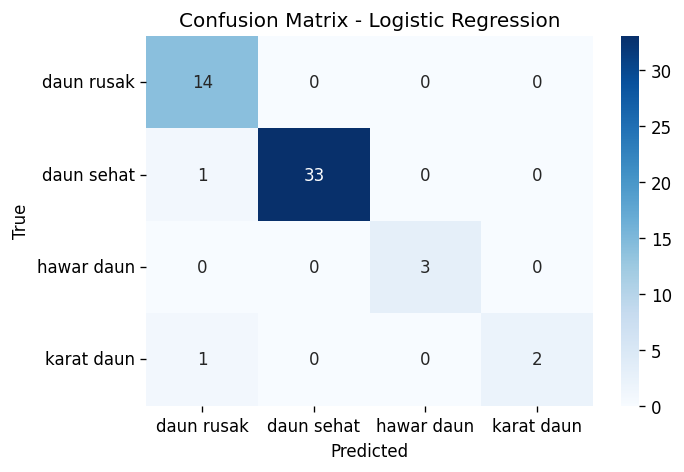

In [30]:
# ===================================================================================
# LOGISTIC REGRESSION
# ===================================================================================

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_train_scaled, y_train)

acc_logreg = evaluate_model(logreg, X_test_scaled, y_test, "Logistic Regression")



    EVALUATION: Decision Tree
Accuracy: 0.8518518518518519

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.82      0.64      0.72        14
  daun sehat       0.92      0.97      0.94        34
  hawar daun       0.50      0.67      0.57         3
  karat daun       0.67      0.67      0.67         3

    accuracy                           0.85        54
   macro avg       0.73      0.74      0.73        54
weighted avg       0.85      0.85      0.85        54



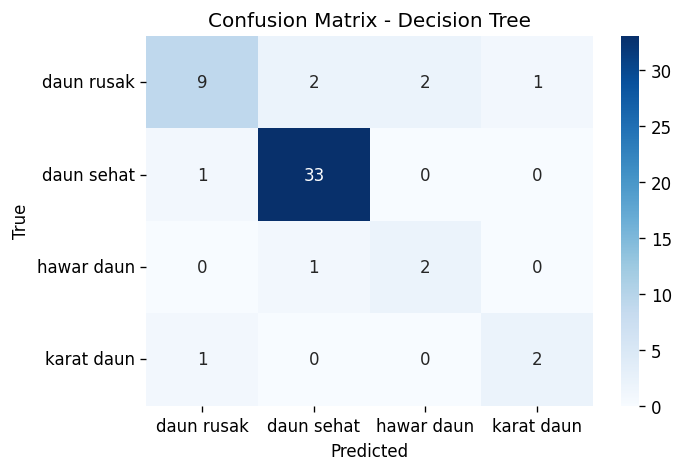

In [31]:
# ===================================================================================
# DECISION TREE
# ===================================================================================

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

acc_dt = evaluate_model(dt, X_test, y_test, "Decision Tree")



    EVALUATION: Random Forest
Accuracy: 0.9629629629629629

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.93      0.93      0.93        14
  daun sehat       0.97      1.00      0.99        34
  hawar daun       1.00      1.00      1.00         3
  karat daun       1.00      0.67      0.80         3

    accuracy                           0.96        54
   macro avg       0.97      0.90      0.93        54
weighted avg       0.96      0.96      0.96        54



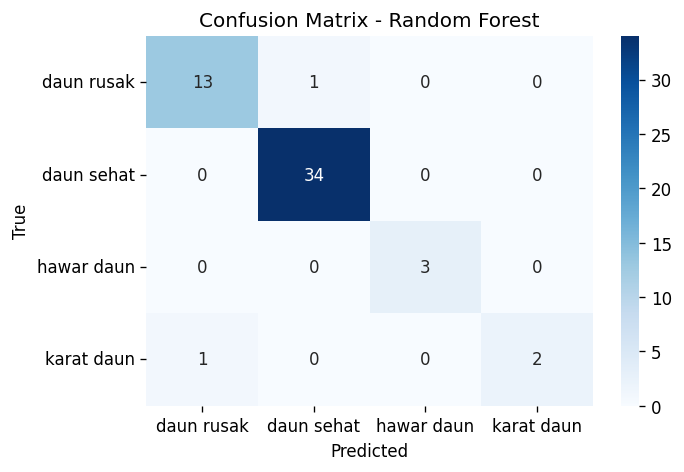

In [32]:
# ===================================================================================
# RANDOM FOREST
# ===================================================================================

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

acc_rf = evaluate_model(rf, X_test, y_test, "Random Forest")


In [ ]:
!pip install xgboost



    EVALUATION: XGBoost
Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.87      0.93      0.90        14
  daun sehat       1.00      1.00      1.00        34
  hawar daun       1.00      0.67      0.80         3
  karat daun       0.67      0.67      0.67         3

    accuracy                           0.94        54
   macro avg       0.88      0.82      0.84        54
weighted avg       0.95      0.94      0.94        54



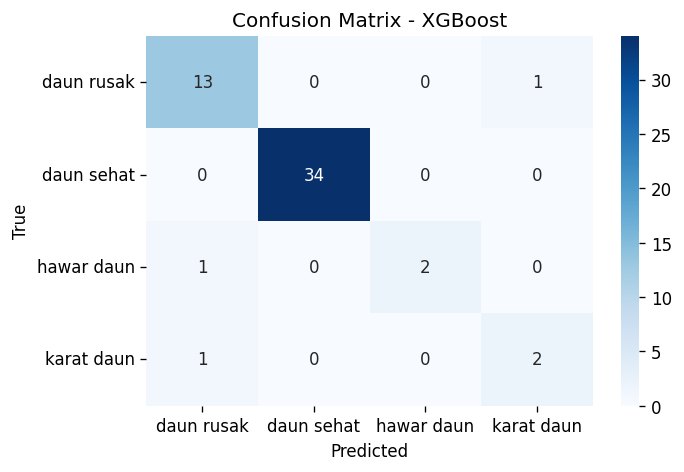

In [33]:
# ===================================================================================
# XGBOOST CLASSIFIER
# ===================================================================================

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    tree_method="hist"  # fast training
)

xgb.fit(X_train, y_train)

acc_xgb = evaluate_model(xgb, X_test, y_test, "XGBoost")


In [34]:
# ===================================================================================
# PERBANDINGAN AKURASI MODEL
# ===================================================================================

model_scores = {
    "Logistic Regression": acc_logreg,
    "Decision Tree": acc_dt,
    "Random Forest": acc_rf,
    "XGBoost": acc_xgb
}

import pandas as pd
df_scores = pd.DataFrame.from_dict(model_scores, orient="index", columns=["Accuracy"])

print("\n=== PERBANDINGAN AKURASI MODEL ===")
display(df_scores.sort_values(by="Accuracy", ascending=False))



=== PERBANDINGAN AKURASI MODEL ===


,Accuracy
Logistic Regression,0.962963
Random Forest,0.962963
XGBoost,0.944444
Decision Tree,0.851852


# Hyperparameter Tunning

In [35]:
# ===================================================================================
# GRID SEARCH: LOGISTIC REGRESSION
# ===================================================================================

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logreg_params = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}

grid_logreg = GridSearchCV(
    LogisticRegression(max_iter=3000),
    logreg_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_logreg.fit(X_train_scaled, y_train)

print("Best Params (LogReg):", grid_logreg.best_params_)
print("Best Score:", grid_logreg.best_score_)


Best Params (LogReg): {'C': 1, 'solver': 'lbfgs'}
Best Score: 1.0


In [36]:
# ===================================================================================
# GRID SEARCH: DECISION TREE
# ===================================================================================

from sklearn.tree import DecisionTreeClassifier

dt_params = {
    "max_depth": [5, 10, 20, None],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [2, 5, 10]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

print("Best Params (Decision Tree):", grid_dt.best_params_)
print("Best Score:", grid_dt.best_score_)


Best Params (Decision Tree): {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Best Score: 0.9237551020408163


In [37]:
# ===================================================================================
# RANDOM SEARCH: RANDOM FOREST
# ===================================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rand_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

rand_rf.fit(X_train, y_train)

print("Best Params (Random Forest):", rand_rf.best_params_)
print("Best Score:", rand_rf.best_score_)


Best Params (Random Forest): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': False}
Best Score: 0.9879183673469388


In [38]:
# ===================================================================================
# RANDOM SEARCH: XGBOOST
# ===================================================================================

from xgboost import XGBClassifier

xgb_params = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

rand_xgb = RandomizedSearchCV(
    XGBClassifier(tree_method="hist", random_state=42),
    xgb_params,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

rand_xgb.fit(X_train, y_train)

print("Best Params (XGBoost):", rand_xgb.best_params_)
print("Best Score:", rand_xgb.best_score_)


Best Params (XGBoost): {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Score: 0.9879999999999999



    EVALUATION: Best Logistic Regression
Accuracy: 0.9629629629629629

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.88      1.00      0.93        14
  daun sehat       1.00      0.97      0.99        34
  hawar daun       1.00      1.00      1.00         3
  karat daun       1.00      0.67      0.80         3

    accuracy                           0.96        54
   macro avg       0.97      0.91      0.93        54
weighted avg       0.97      0.96      0.96        54



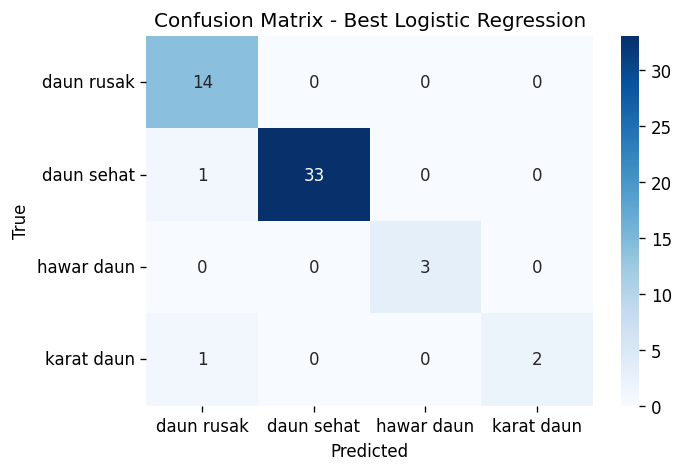


    EVALUATION: Best Decision Tree
Accuracy: 0.8888888888888888

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.75      0.86      0.80        14
  daun sehat       1.00      0.94      0.97        34
  hawar daun       0.67      0.67      0.67         3
  karat daun       0.67      0.67      0.67         3

    accuracy                           0.89        54
   macro avg       0.77      0.78      0.78        54
weighted avg       0.90      0.89      0.89        54



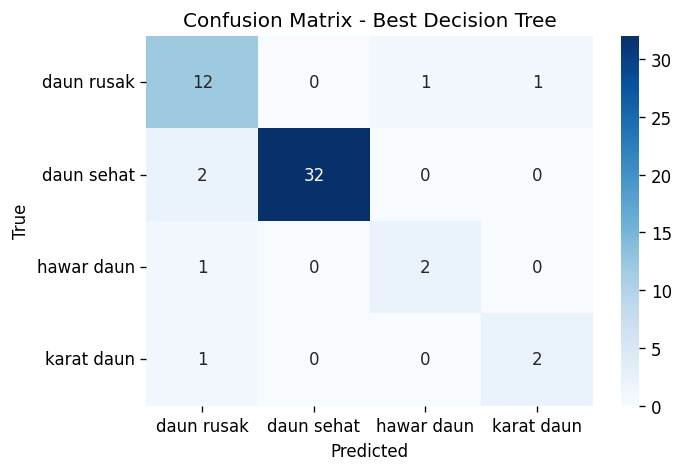


    EVALUATION: Best Random Forest
Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.92      0.86      0.89        14
  daun sehat       0.94      1.00      0.97        34
  hawar daun       1.00      1.00      1.00         3
  karat daun       1.00      0.67      0.80         3

    accuracy                           0.94        54
   macro avg       0.97      0.88      0.92        54
weighted avg       0.95      0.94      0.94        54



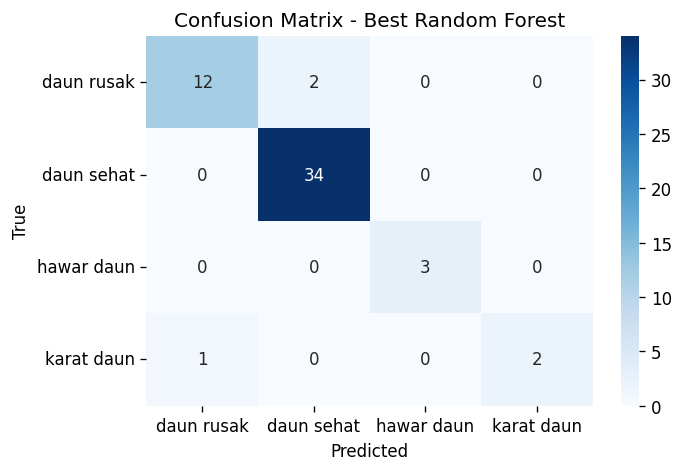


    EVALUATION: Best XGBoost
Accuracy: 0.9629629629629629

Classification Report:
               precision    recall  f1-score   support

  daun rusak       0.88      1.00      0.93        14
  daun sehat       1.00      1.00      1.00        34
  hawar daun       1.00      0.67      0.80         3
  karat daun       1.00      0.67      0.80         3

    accuracy                           0.96        54
   macro avg       0.97      0.83      0.88        54
weighted avg       0.97      0.96      0.96        54



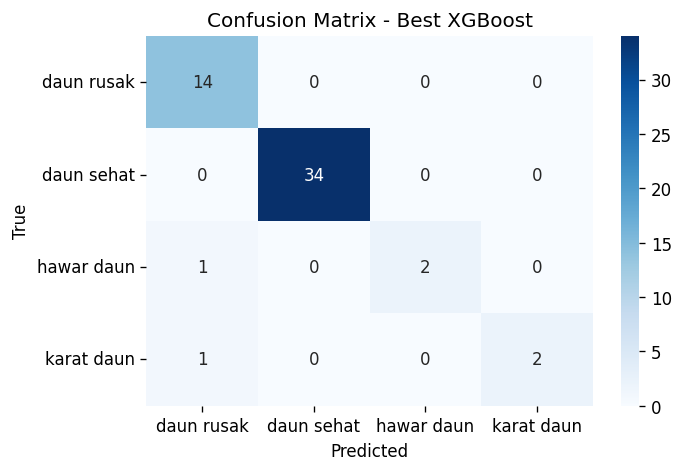

In [39]:
# ===================================================================================
# MODEL FINAL EVALUATION
# ===================================================================================

best_logreg = grid_logreg.best_estimator_
best_dt     = grid_dt.best_estimator_
best_rf     = rand_rf.best_estimator_
best_xgb    = rand_xgb.best_estimator_

acc_best_logreg = evaluate_model(best_logreg, X_test_scaled, y_test, "Best Logistic Regression")
acc_best_dt     = evaluate_model(best_dt, X_test, y_test, "Best Decision Tree")
acc_best_rf     = evaluate_model(best_rf, X_test, y_test, "Best Random Forest")
acc_best_xgb    = evaluate_model(best_xgb, X_test, y_test, "Best XGBoost")


In [40]:
tuned_results = {
    "LogReg (Tuned)": acc_best_logreg,
    "DecisionTree (Tuned)": acc_best_dt,
    "RandomForest (Tuned)": acc_best_rf,
    "XGBoost (Tuned)": acc_best_xgb
}

df_tuned = pd.DataFrame.from_dict(tuned_results, orient="index", columns=["Accuracy"])
print("\n=== PERBANDINGAN AKURASI MODEL SETELAH TUNING ===")
display(df_tuned.sort_values("Accuracy", ascending=False))



=== PERBANDINGAN AKURASI MODEL SETELAH TUNING ===


,Accuracy
LogReg (Tuned),0.962963
XGBoost (Tuned),0.962963
RandomForest (Tuned),0.944444
DecisionTree (Tuned),0.888889


# SHAP EXPLAINABILITY

In [ ]:
!pip install shap


In [42]:
# ===================================================================================
# SHAP EXPLAINABILITY UNTUK XGBOOST
# ===================================================================================

import shap

explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)


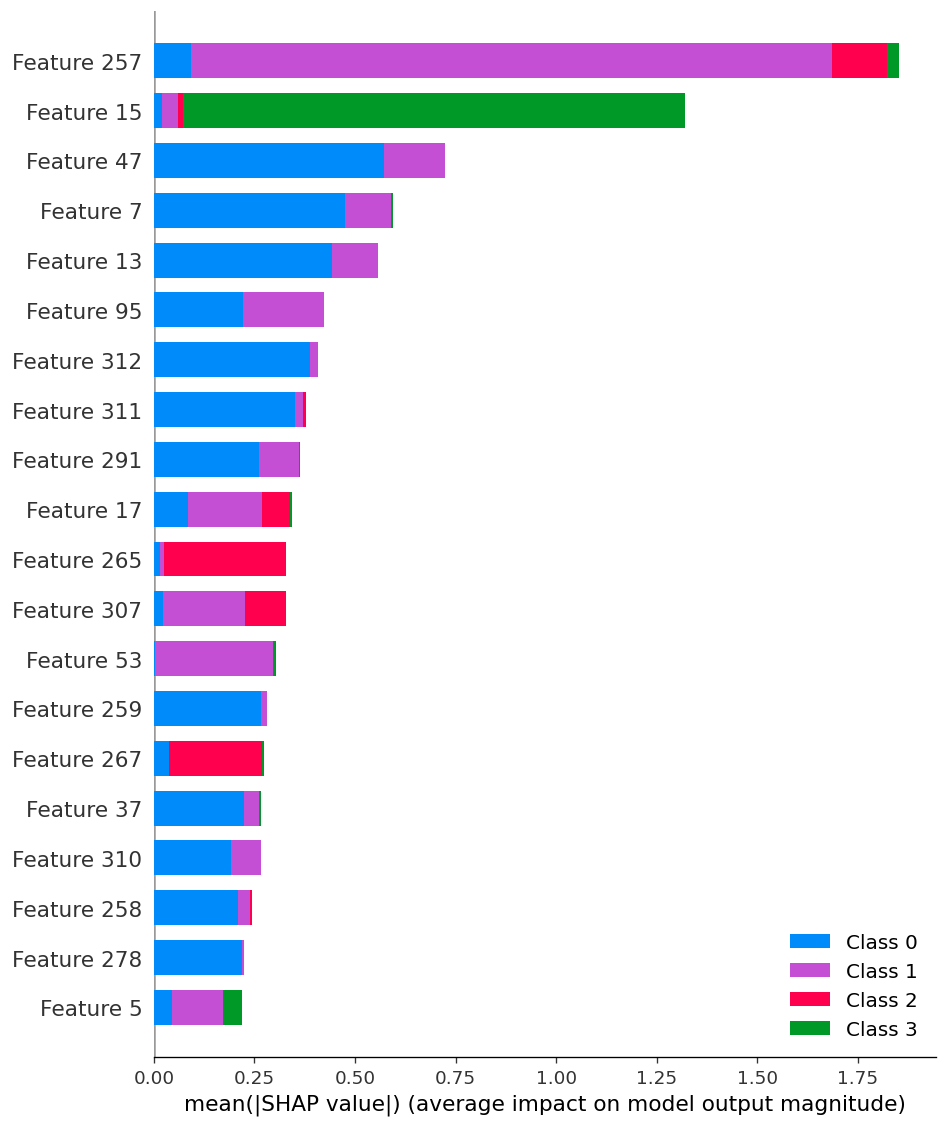

In [43]:
# Plot summary SHAP
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")


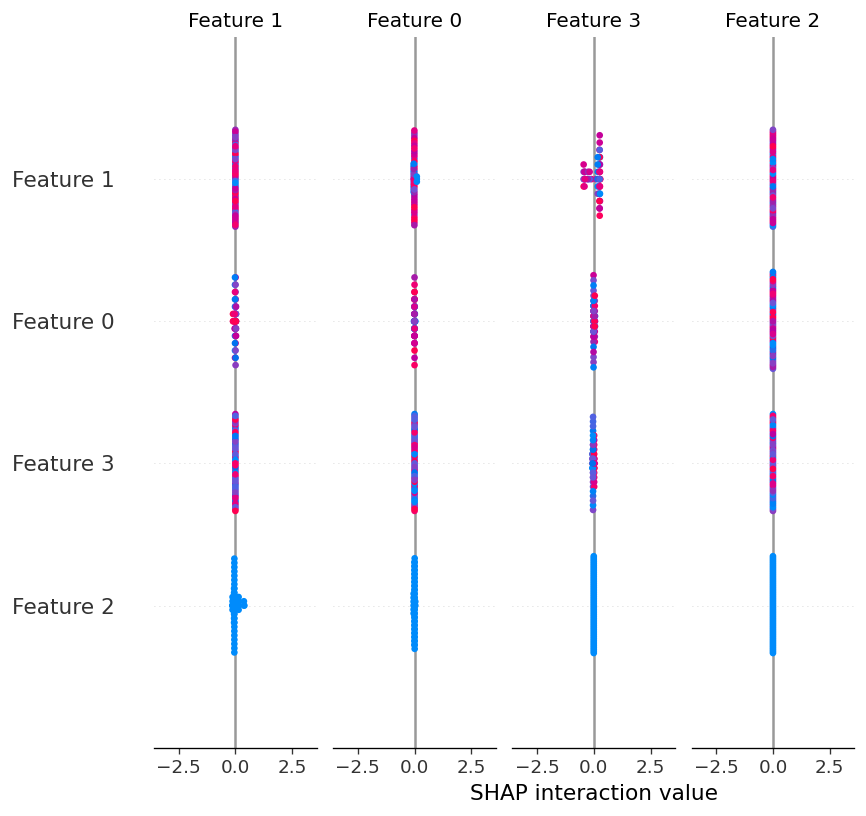

In [51]:
shap.summary_plot(shap_values_xgb, X_test)


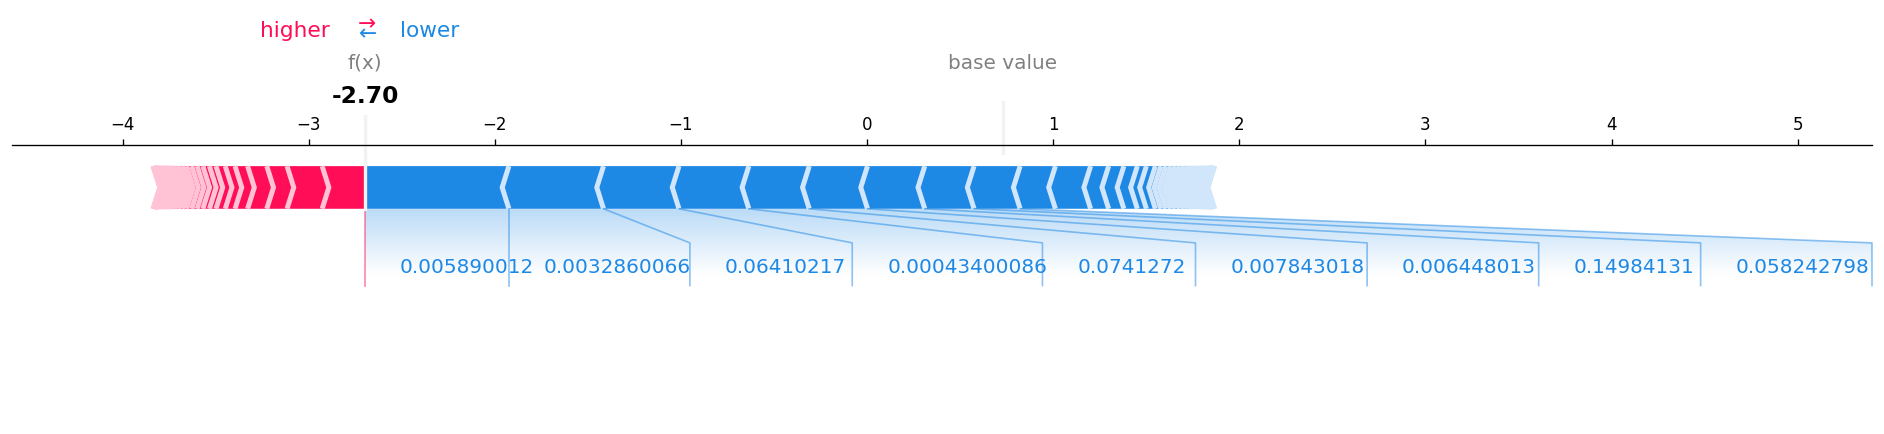

In [46]:
idx = 5  # misal sample ke-5
shap.force_plot(
    explainer_xgb.expected_value[0], # Specify class for expected_value
    shap_values_xgb[idx][:, 0],     # Specify class for shap_values
    X_test[idx],
    matplotlib=True
)

In [53]:
# Ranking fitur berdasarkan mean(|SHAP|)
shap_abs = np.abs(shap_values_xgb).mean(axis=0)
feature_order = np.argsort(shap_abs)[::-1]

print("Top 10 Most Important Features:", feature_order[:10])



Top 10 Most Important Features: [[3 2 1 0]
 [3 2 1 0]
 [3 2 1 0]
 [1 3 0 2]
 [3 2 1 0]
 [3 0 2 1]
 [1 3 0 2]
 [3 2 1 0]
 [1 2 3 0]
 [3 1 2 0]]


In [59]:
print(feature_order[:10])


[257  15  47   7  13  95 312 311 291  17]


In [60]:
print(np.array(shap_values_xgb).shape)
# 54 = jumlah sampel test
# 313 = jumlah fitur (FINE + COARSE + DOR)
# 4 = jumlah kelas (daun sehat, daun rusak, hawar, karat)

(54, 313, 4)


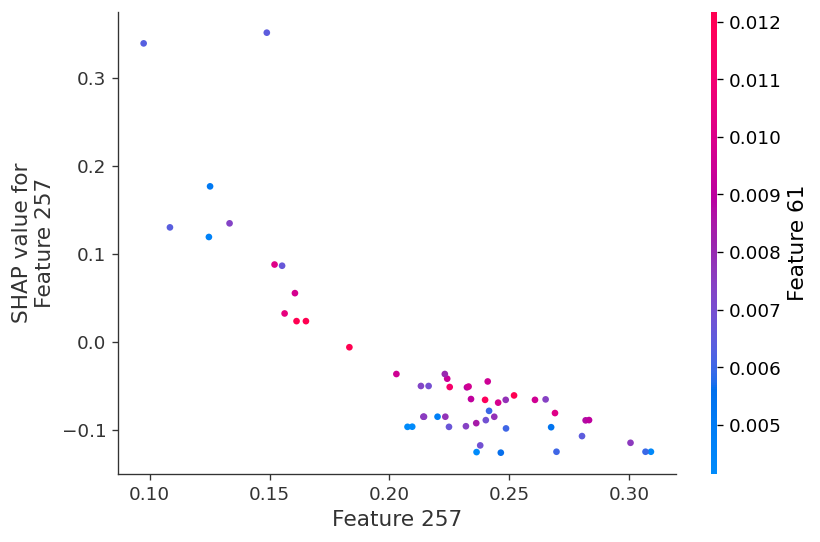

In [61]:
best_feature = feature_order[0]  # 257

shap.dependence_plot(
    best_feature,
    shap_values_xgb[:, :, 0],  # SHAP values untuk kelas 0
    X_test
)


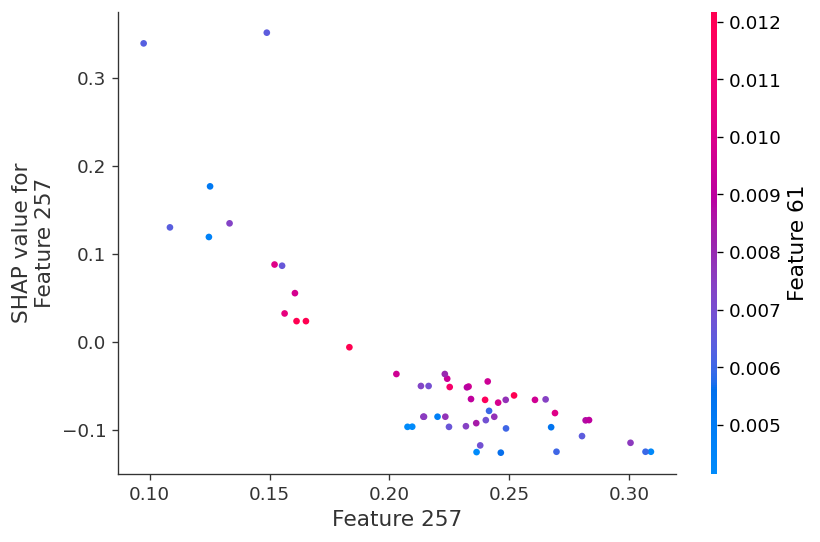

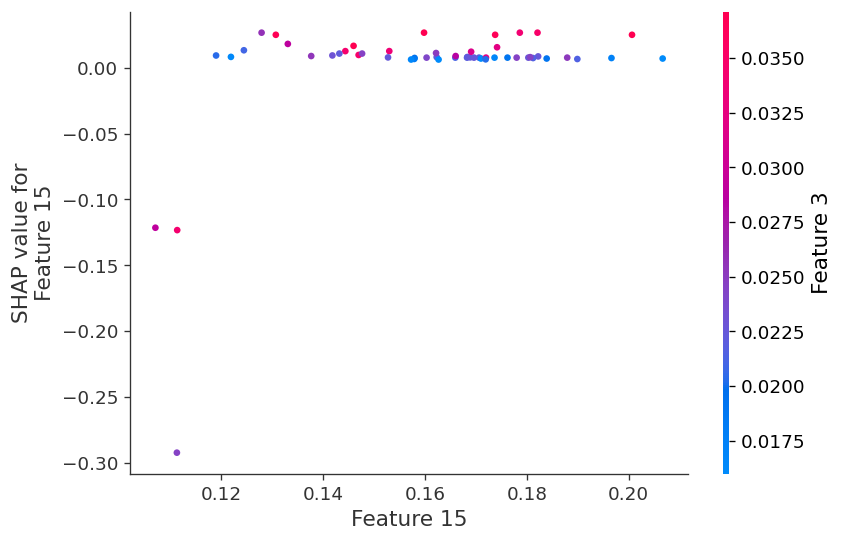

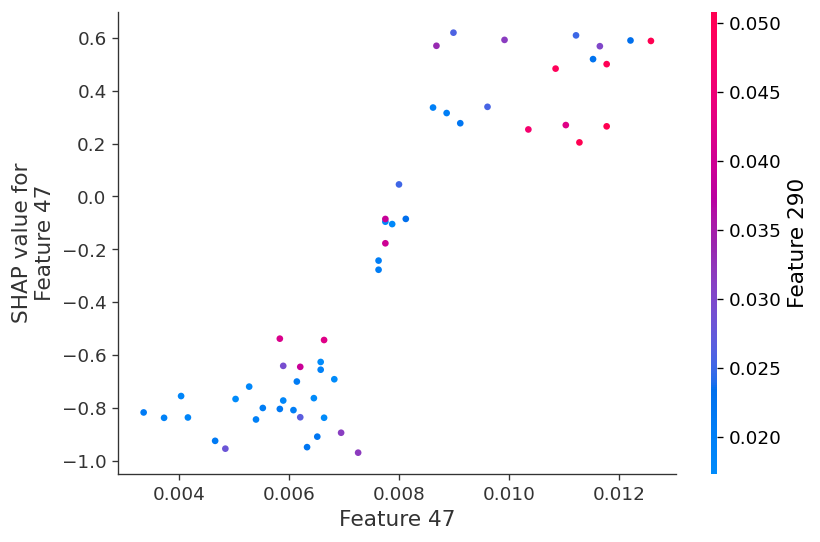

In [62]:
top_features = feature_order[:3]   # [257, 15, 47]

for f in top_features:
    shap.dependence_plot(
        f,
        shap_values_xgb[:, :, 0],  # fokus kelas 0
        X_test
    )

Dependence Plot untuk kelas: Daun Sehat


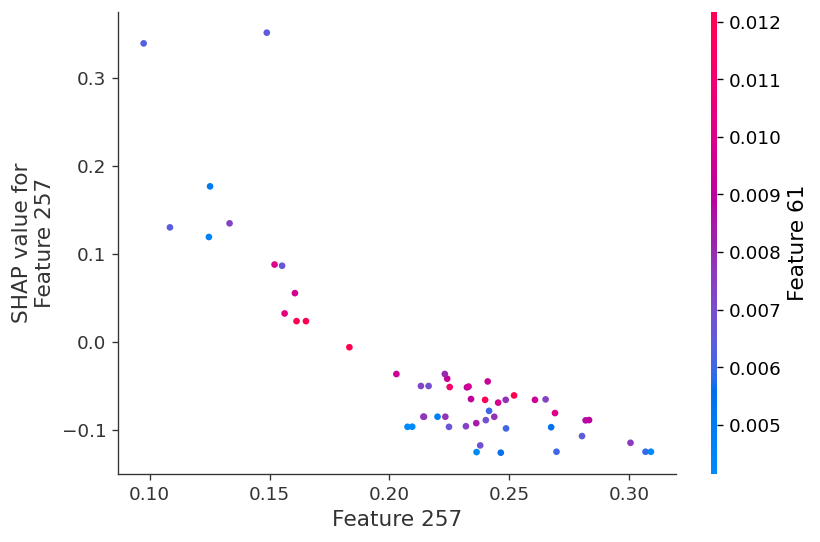

Dependence Plot untuk kelas: Daun Rusak


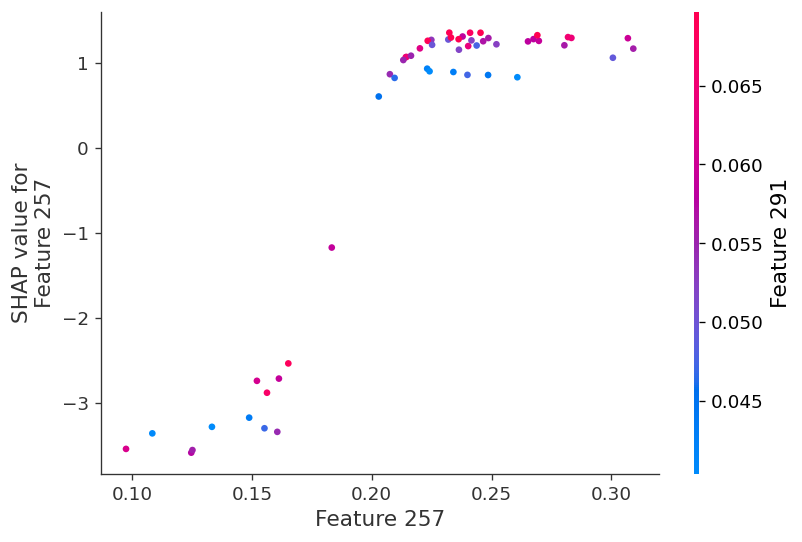

Dependence Plot untuk kelas: Hawar Daun


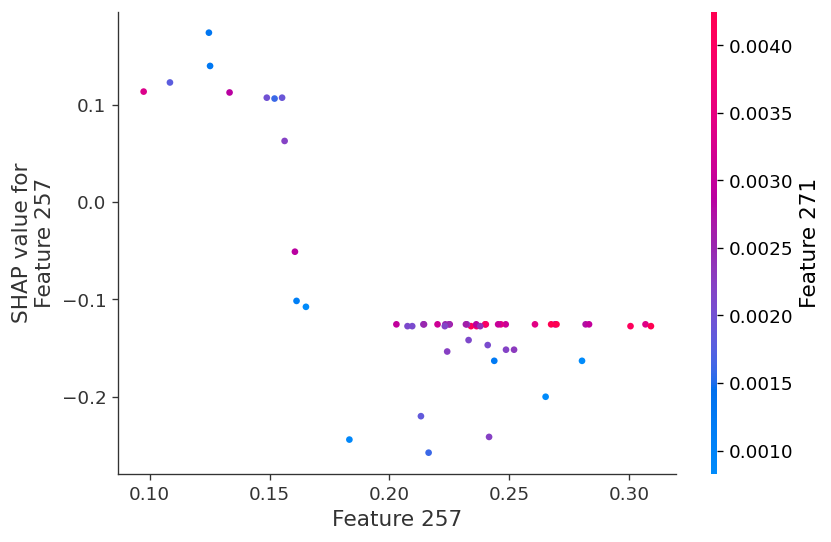

Dependence Plot untuk kelas: Karat Daun


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


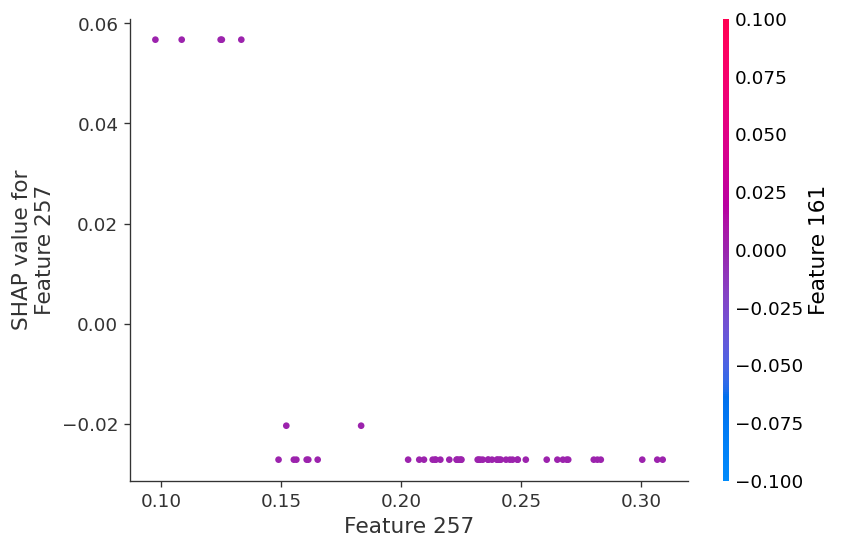

In [63]:
class_names = ["Daun Sehat", "Daun Rusak", "Hawar Daun", "Karat Daun"]

for cls in range(4):
    print("Dependence Plot untuk kelas:", class_names[cls])
    shap.dependence_plot(
        best_feature,
        shap_values_xgb[:, :, cls],
        X_test
    )


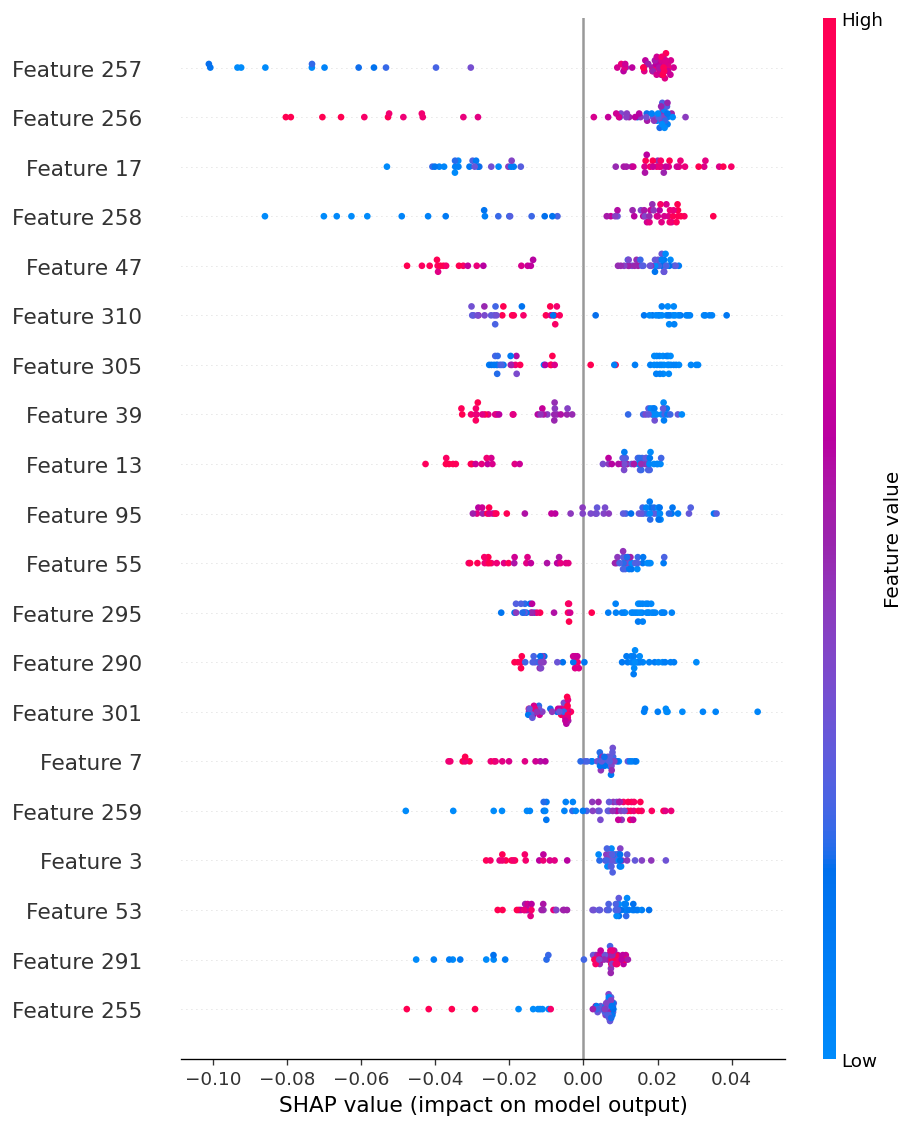

In [50]:
# ===================================================================================
# SHAP UNTUK RANDOM FOREST
# ===================================================================================

explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_test)

shap.summary_plot(shap_values_rf[:, :, 1], X_test)  # kelas 1 contoh

# download

In [2]:
!pip install joblib

In [69]:
import joblib
joblib.dump(best_xgb, "xgb_best_model.pkl")


['xgb_best_model.pkl']

In [70]:
from google.colab import files
files.download("xgb_best_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
joblib.dump(scaler, "scaler.pkl")


NameError: name 'joblib' is not defined

In [64]:

# ===================================================================================
# LOAD DATASET & GENERATE FITUR
# ===================================================================================

def load_dataset(base_dir, class_map, max_images_per_class=None):
    """
    Memuat citra daun jagung dari struktur folder dan menghasilkan fitur.

    - Loop setiap folder kelas sesuai class_map.
    - Preprocessing (resize, RGB, normalisasi, grayscale).
    - Segmentasi Otsu (untuk visualisasi / konsistensi pipeline).
    - Ekstraksi fitur (fine + coarse + DOR).

    Parameters
    ----------
    base_dir : str
        Folder utama dataset.
    class_map : dict
        Mapping nama folder -> label (string).
    max_images_per_class : int or None
        Batas jumlah citra per kelas (opsional).

    Returns
    -------
    X : np.ndarray
        Matriks fitur (num_samples x num_features).
    y : np.ndarray
        Label kelas untuk setiap sampel.
    paths : list of str
        Path citra yang digunakan.
    """
    X_list = []
    y_list = []
    paths = []

    for folder_name, label in class_map.items():
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            print(f"[PERINGATAN] Folder tidak ditemukan: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        files = sorted(files)
        if max_images_per_class is not None:
            files = files[:max_images_per_class]

        print(f"Memproses kelas '{folder_name}' ({label}), jumlah citra: {len(files)}")

        for fname in files:
            fpath = os.path.join(folder_path, fname)
            img = cv2.imread(fpath)
            if img is None:
                print("  [SKIP] Gagal baca citra:", fpath)
                continue

            rgb_norm, gray = preprocess_image(img)
            _ = segment_otsu(gray)  # tidak digunakan langsung untuk fitur di sini

            feat = extract_all_features(gray)
            X_list.append(feat)
            y_list.append(label)
            paths.append(fpath)

    if not X_list:
        print("Tidak ada citra yang berhasil dimuat. Pastikan jalur dan struktur folder sudah benar.")
        return np.array([]), np.array([]), []

    X = np.vstack(X_list).astype("float32")
    y = np.array(y_list)
    print("\nTotal sampel:", X.shape[0])
    print("Dimensi fitur:", X.shape[1])
    return X, y, paths


# Jalankan loading dataset

# BASE_DIR and CLASS_MAP are already defined in cell DP7a2QUo2Q_F
X, y, img_paths = load_dataset(BASE_DIR, CLASS_MAP, max_images_per_class=None)


Memproses kelas 'daun sehat' (HL), jumlah citra: 227
Memproses kelas 'daun rusak' (DMG), jumlah citra: 97
Memproses kelas 'hawar daun' (NLB), jumlah citra: 15
Memproses kelas 'karat daun' (RS), jumlah citra: 18

Total sampel: 357
Dimensi fitur: 313


In [65]:

# ===================================================================================
# TRAINING EKNN
# ===================================================================================

X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, img_paths, test_size=0.2, random_state=42, stratify=y
)

print("Ukuran train:", X_train.shape, "Ukuran test:", X_test.shape)

# Enhanced KNN: struktur classifier tetap KNN,
# tetapi fitur yang dimasukkan sudah "enhanced" (fine + coarse + DOR).
eknn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
eknn.fit(X_train, y_train)

print("Model EKNN selesai dilatih.")


Ukuran train: (285, 313) Ukuran test: (72, 313)
Model EKNN selesai dilatih.



Classification Report:

              precision    recall  f1-score   support

         DMG     0.8947    0.8947    0.8947        19
          HL     0.9574    0.9783    0.9677        46
         NLB     1.0000    1.0000    1.0000         3
          RS     1.0000    0.7500    0.8571         4

    accuracy                         0.9444        72
   macro avg     0.9630    0.9057    0.9299        72
weighted avg     0.9450    0.9444    0.9437        72



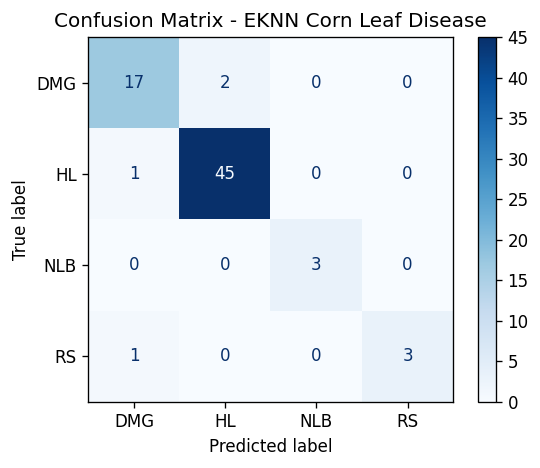

In [66]:

# ===================================================================================
# EVALUASI: CONFUSION MATRIX & CLASSIFICATION REPORT
# ===================================================================================

y_pred = eknn.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

labels_sorted = sorted(list(set(y)))
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix - EKNN Corn Leaf Disease")
plt.tight_layout()
plt.show()


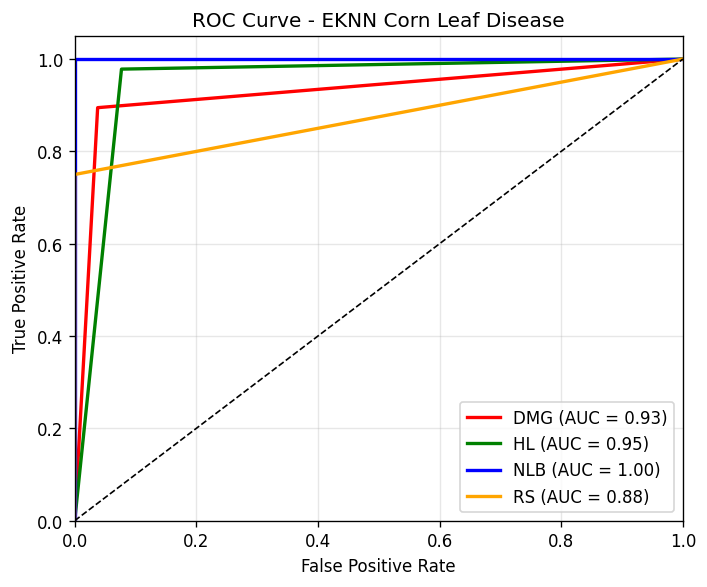

In [67]:

# ===================================================================================
# EVALUASI: ROC CURVE MULTI-KELAS
# ===================================================================================

classes = sorted(list(set(y)))
y_test_bin = label_binarize(y_test, classes=classes)
y_score_bin = label_binarize(y_pred, classes=classes)

plt.figure(figsize=(6, 5))
colors = cycle(["red", "green", "blue", "orange", "purple", "brown"])

for i, color in zip(range(len(classes)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - EKNN Corn Leaf Disease")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
